<a href="https://colab.research.google.com/github/DarShabi/OCR-Company-Project/blob/main/Week%231/EDA_Initial_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ImageHash

In [64]:
!apt-get install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (12.2 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120828 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

In [60]:
!pip install -q langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [67]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import json
from collections import Counter, defaultdict
import re
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import imagehash
import pytesseract
from langdetect import detect, LangDetectException

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
root_folder = "/content/drive/MyDrive/Data/Data_samples"

# EDA Functions

In [5]:
def load_images_and_annotations_from_folders(root_folder):
    """
    Loads all images and corresponding JSON annotations from subfolders.

    Parameters:
    root_folder (str): Path to the root folder.

    Returns:
    list, list: A list of paths to the images and a list of corresponding annotations (dictionaries).
    """
    img_paths = []
    texts = []
    # Iterate through all subdirectories
    for subdir, dirs, files in os.walk(root_folder):
        for file in files:
            # Process only .jpg files that do not contain 'thumb' in their names
            if file.endswith('.jpg') and 'thumb' not in file:
                img_path = os.path.join(subdir, file)
                # Construct corresponding .analysis.json file path
                json_path = os.path.splitext(img_path)[0] + '.analysis.json'
                # Check if corresponding .analysis.json file exists
                if os.path.isfile(json_path):
                    img_paths.append(img_path)
                    with open(json_path, 'r') as json_file:
                        annotation = json.load(json_file)
                        texts.append(annotation)
                else:
                    print(f"file {img_path} does not have corresponding .analysis.json file.")
    return img_paths, texts

In [6]:
def image_properties(img_paths):
    """
    Analyze and plot the properties of images: width, height, mode (color scale)

    Parameters:
    img_paths (list): A list of paths to the images.

    """
    widths = []
    heights = []
    modes = []

    for path in img_paths:
        with Image.open(path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)
            modes.append(img.mode)

    # Plotting
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(widths, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Width')
    plt.ylabel('Frequency')
    plt.title('Image Widths')

    plt.subplot(1, 3, 2)
    plt.hist(heights, bins=20, color='salmon', edgecolor='black')
    plt.xlabel('Height')
    plt.ylabel('Frequency')
    plt.title('Image Heights')

    plt.subplot(1, 3, 3)
    plt.hist(modes, bins=20, color='lightgreen', edgecolor='black')
    plt.xlabel('Mode')
    plt.ylabel('Frequency')
    plt.title('Image Modes')

    plt.tight_layout()
    plt.show()



In [7]:
def image_quality(img_paths):
    """
    Analyze and plot the average pixel intensity (brightness) of images

    Parameters:
    img_paths (list): A list of paths to the images.

    """
    avg_intensities = []

    for path in img_paths:
        with Image.open(path) as img:
            img_gray = img.convert("L")  # convert image to grayscale
            avg_intensity = np.array(img_gray).mean()
            avg_intensities.append(avg_intensity)

    plt.hist(avg_intensities, bins=20)
    plt.title('Image Average Intensity')
    plt.xlabel('Average Intensity')
    plt.ylabel('Frequency')
    plt.show()


In [8]:
def text_length_distribution(texts, n_samples):
    """
    Analyze and plot the length distribution of texts with KDE.

    Parameters:
    texts (list): A list of texts.

    """
    lengths = [len(text['text']) for text in texts]

    sns.histplot(lengths, bins=60, kde=True)
    plt.title('Text Length Distribution')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.xlim(min(lengths), max(lengths))
    plt.ylim(0, n_samples)
    plt.show()



In [9]:
def explore_unique_fields(texts):
    """
    Explore all available fields in the .anlysis.json files
    Parameters:
    texts (list): list of the annotation (dictionaries).

    Returns:
    fields_counts (collections.defaultdict object): unique fields and their counts.
    """
    fields_counts = defaultdict(int)

    # Function to flatten nested dictionaries
    def flatten(d, parent_key='', sep='_'):
        items = {}
        for k, v in d.items():
            new_key = parent_key + sep + k if parent_key else k
            if isinstance(v, dict):
                items.update(flatten(v, new_key, sep=sep))
            else:
                items[new_key] = v
        return items

    # Iterate through texts and process each text
    for text in texts:
        flat_annotation = flatten(text)
        for field in flat_annotation:
            fields_counts[field] += 1

    return fields_counts


In [10]:
def find_images_without_json(root_folder):
    """
    Find images in the given root directory that do not have corresponding .analysis.json files.

    Parameters:
    root_folder (str): Path to the root folder containing subdirectories with images and JSON files.

    Returns:
    int: The count of images without corresponding .analysis.json files.
    list: A list containing the paths of images without corresponding .analysis.json files.
    """
    missing_json_images = []

    # Iterate through all subdirectories
    for subdir, dirs, files in os.walk(root_folder):
        for file in files:
            # Process only .jpg files that do not contain 'thumb' in their names
            if file.endswith('.jpg') and 'thumb' not in file:
                img_path = os.path.join(subdir, file)
                json_path = img_path[:-4] + '.analysis.json'
                # Check if corresponding .analysis.json file does not exist
                if not os.path.isfile(json_path):
                    missing_json_images.append(img_path)

    # Display images
    for idx, img_path in enumerate(missing_json_images):
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"Image {idx + 1}")
        plt.axis('off')
        plt.show()

    return len(missing_json_images), missing_json_images


In [11]:

def plot_image_properties_vs_text(img_paths, texts):
    """
    Plots scatter plots comparing image properties (height, width, mode) to text length and a bar plot for modes.

    Parameters:
    img_paths (list of str): Paths to the images to be analyzed.
    texts (list of dict): Dictionaries containing text annotations for the images.
    """
    heights = []
    widths = []
    modes = defaultdict(int)
    text_lengths = []

    for img_path, annotation in zip(img_paths, texts):
        with Image.open(img_path) as img:
            width, height = img.size
            modes[img.mode] += 1
            widths.append(width)
            heights.append(height)
            text_lengths.append(len(annotation['text']))

    # Scatter plot Height vs Text Length
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.scatter(heights, text_lengths, c='skyblue', edgecolor='black')
    plt.title('Height vs Text Length')
    plt.xlabel('Height')
    plt.ylabel('Text Length')

    # Scatter plot Width vs Text Length
    plt.subplot(1, 3, 2)
    plt.scatter(widths, text_lengths, c='salmon', edgecolor='black')
    plt.title('Width vs Text Length')
    plt.xlabel('Width')
    plt.ylabel('Text Length')

    # Scatter plot Mode vs Text Length
    plt.subplot(1, 3, 3)
    plt.bar(list(modes.keys()), list(modes.values()),  color='lightgreen', edgecolor='black')
    plt.title('Mode vs Text Length')
    plt.xlabel('Mode')
    plt.ylabel('Text Length')
    plt.show()


In [12]:
def find_anomalies(img_paths, texts, text_length_threshold=1000, width_threshold=5000, height_threshold=3000):
    """
    Identifies and displays the texts with lengths over a given threshold, and the images with widths or heights over given thresholds.
    It also prints the first 5 instances of each anomaly.

    Parameters:
    img_paths (list): A list of paths to the images.
    texts (list): A list of text annotations.
    text_length_threshold (int, optional): Length threshold for considering a text anomalous. Default is 1000.
    width_threshold (int, optional): Width threshold for considering an image anomalous. Default is 5000.
    height_threshold (int, optional): Height threshold for considering an image anomalous. Default is 3000.

    Returns:
    tuple: A tuple containing two lists - the anomalous texts and the information about anomalous images (path, width, height).
    """
    anomalous_texts = [text for text in texts if len(text['text']) > text_length_threshold]
    anomalous_images = []

    print(f"----------Texts with length over {text_length_threshold}----------\n\n")
    for idx, text in enumerate(anomalous_texts[:5]): # Displaying and printing the first 5 extra-long texts
        print(text['text'])
        img_path = img_paths[texts.index(text)] # Assuming the text index matches the image index
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
        print("-----------------------------------------------------------------\n\n")

    print(f"\n----------Images with width over {width_threshold} or height over {height_threshold}----------\n\n")
    for idx, path in enumerate(img_paths):
        with Image.open(path) as img:
            width, height = img.size
            if width > width_threshold or height > height_threshold:
                anomalous_images.append((path, width, height))
                if len(anomalous_images) <= 5: # Displaying and printing the first 5 images with abnormal shapes
                    print(f"Path: {path}, Width: {width}, Height: {height} \n\n")
                    plt.imshow(img)
                    plt.show()

    print("-------------------------------DONE!!!--------------------------------")
    return anomalous_texts, anomalous_images




# Executing

In [13]:
# Load images and annotations
img_paths, texts = load_images_and_annotations_from_folders(root_folder)

file /content/drive/MyDrive/Data/Data_samples/forum_forumkorner/1723061f0c317f2faa27f9193bb70e9d (1).jpg does not have corresponding .analysis.json file.
file /content/drive/MyDrive/Data/Data_samples/forum_forumkorner/1fac3bae0a135b4ef68b3fc32a8c0404 (1).jpg does not have corresponding .analysis.json file.
file /content/drive/MyDrive/Data/Data_samples/forum_forumkorner/37e9a9fca564bd196adff802f739ec81 (1).jpg does not have corresponding .analysis.json file.
file /content/drive/MyDrive/Data/Data_samples/forum_cssforum/0158efb0a1beb8cb37b1064fdb8d899c (2).jpg does not have corresponding .analysis.json file.
file /content/drive/MyDrive/Data/Data_samples/forum_cssforum/0158efb0a1beb8cb37b1064fdb8d899c (1).jpg does not have corresponding .analysis.json file.
file /content/drive/MyDrive/Data/Data_samples/forum_cssforum/01e9cf7428895ddd0d5a7d4c4fa9ba73 (2).jpg does not have corresponding .analysis.json file.
file /content/drive/MyDrive/Data/Data_samples/forum_cssforum/01e9cf7428895ddd0d5a7d4c

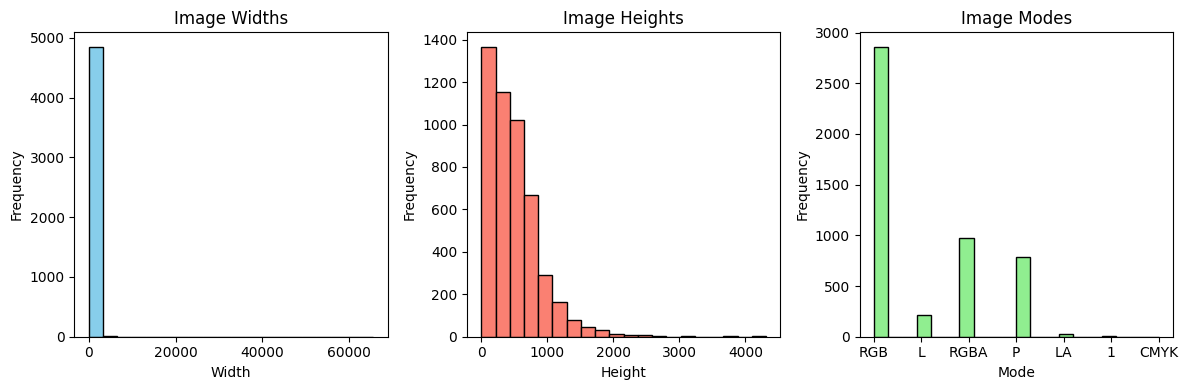

In [14]:
# Execute EDA functions
image_properties(img_paths)

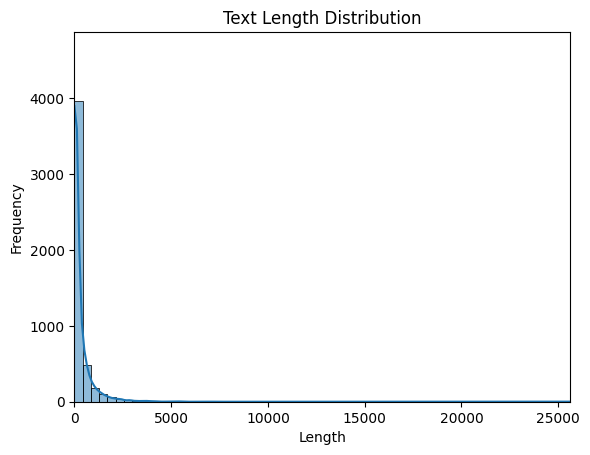

In [15]:
# Execute EDA functions
num_img=len(img_paths)
text_length_distribution(texts, num_img)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


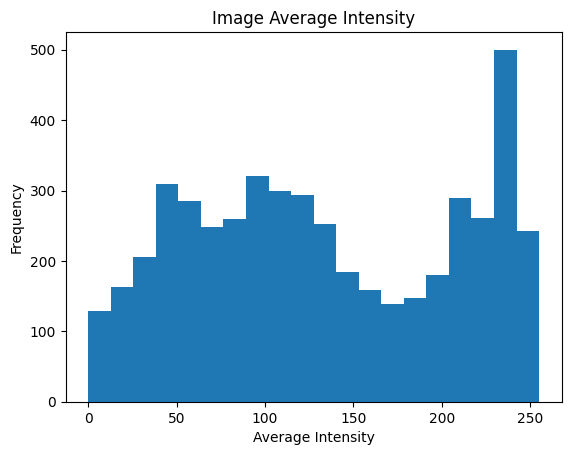

In [16]:
# Execute EDA functions
image_quality(img_paths)

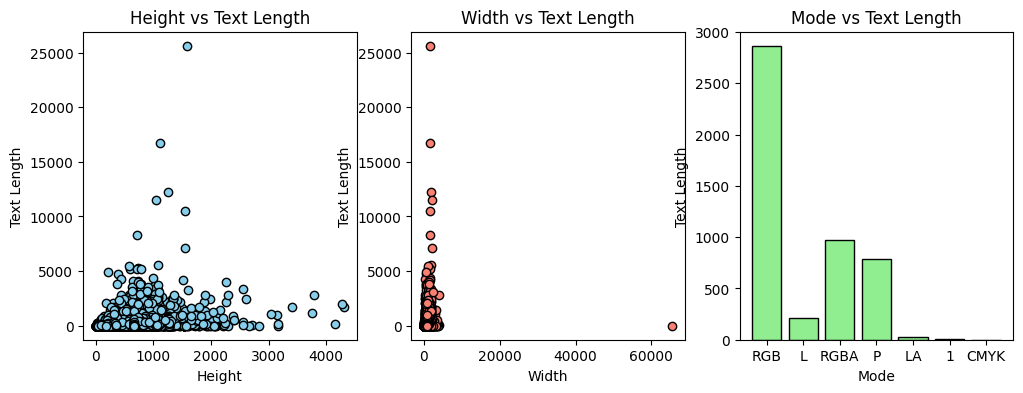

In [17]:
# Execute EDA functions
plot_image_properties_vs_text(img_paths, texts)

In [18]:
type(texts[0])

dict

In [19]:
print(texts[0])

{'ocr_text_info': {'all_text': 'Aloha\nW LEREEE\n3imL.\nT19\nucket\nAIR CALIFORNIA\nS storeshare.\nexgu\nLana\nBXS\noptegraPIS\nGrod\nnates\n', 'is_arabic': False}, 'safe_search': {'medical': 1, 'spoof': 1, 'violence': 1, 'adult': 1}, 'size': {'width': 1024, 'height': 744}, 'text': 'Aloha\nW LEREEE\n3imL.\nT19\nucket\nAIR CALIFORNIA\nS storeshare.\nexgu\nLana\nBXS\noptegraPIS\nGrod\nnates\n', 'is_emoji': False}


In [20]:
fields_counts = explore_unique_fields(texts)
for field, count in fields_counts.items():
    print(f"Field: {field} ----- Count: {count}")

Field: ocr_text_info_all_text ----- Count: 2110
Field: ocr_text_info_is_arabic ----- Count: 2524
Field: safe_search_medical ----- Count: 4868
Field: safe_search_spoof ----- Count: 4868
Field: safe_search_violence ----- Count: 4868
Field: safe_search_adult ----- Count: 4868
Field: size_width ----- Count: 4859
Field: size_height ----- Count: 4859
Field: text ----- Count: 4868
Field: is_emoji ----- Count: 2817


In [21]:
print(f"Image count: {len(img_paths)}")
print(f"Texts count: {len(texts)}")

Image count: 4868
Texts count: 4868


----------Texts with length over 1000----------


WARBIRDS SERIES
DRAGON
The Avea Wcan played an ipotani le s stalg bonter Fon 1969 0 14 For more hen 30 years dong he begh Be Cold Wa
trat amedwth nuder bonbs wasmady la deler feegn natons such es be Soviel Uhon fom aacing Great Brtein Operaled by he Voonber
coss-section made Edes for penetrating eny arigace le delver ts noclear paoed should the need bave aen Alots of 134 Vcas wert
manuadured, with econd tranche kiown a he 2 being he mod comon Aloal of4581 and 82 arct were produced up 15
The 82 featured larger and thinner wngs hlea geter fuel capecity ofered a ousng
electonics and rada This indudes, bo he nid 1s onrds teinolovng radane nodecne ad a pasve reder waning syslen ie he
tn Late e . he Aro Mcan wi d for conertional bombing mons ost sotcesly apnt Argentira darng he Falands Var of 192
Far tvee decades the Wiean ployed an nponant le in he Cold Wir before ws ventualy sigerseded by he Tanad
eof TAn. Eaise hed eproved equpmeni such as

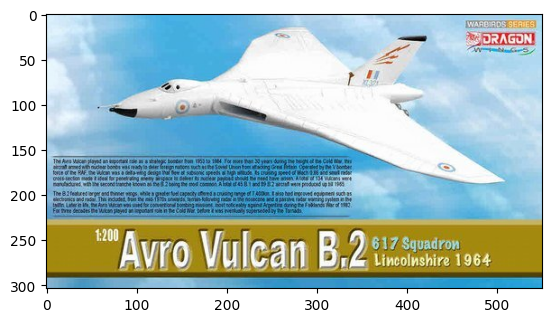

-----------------------------------------------------------------


8 https://www.diecastaircraftforum.com/showthread.php?p=2782288&posted=1#post2782288
田
XAnet Anet pics O FR24
O Rota
- Bmail
Bos Hotm M Gmail A 400
O YT
W wiki
O EGPF
E Taobao
ebay
a Amzn
C/tax
. Flickr
ab ARD
M Magpie
xe XE
Today, 017 PM
5 (permalink)
E Re: Cookles permission popup notice on site
Big Al
17 years collecting
Quote:
Originally Posted by vs-Admin a
Do you have any form of ad blocker, cookie blocker, or tracking blocker added to your browser? What browser are you using?
Kevin
Welcome to DiecastAircraftForum.com
Not that I'm aware of Kevin ?
en on my Chrome browser/phone.
Doin Date: Feb 2005
Location: Near GLA
Posts: 5.958
In support of our communities, we and our 3rd party
partners set cookies to deliver personalized content
and ads.
Let's be having, the Bri
edit quete . quick
post reply
By continuing to use this forum, including clicking the 'OK, understood!
button below, you consent to the use of collect

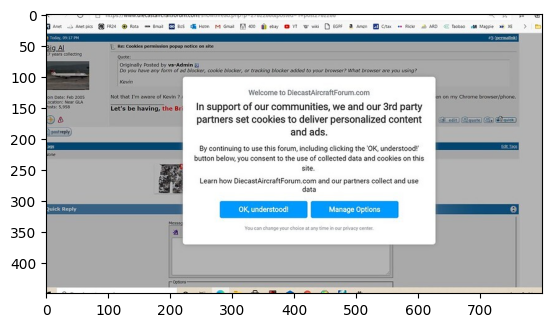

-----------------------------------------------------------------


Аудитория
Это видео отмечено как не предназначенное для детей Задано вами
указывать эту информацию требуется в целях соблюдения Закона США о защите
личных сведений детей в Интернете (COPPA) и/или других законодательных актов.
Требование распространяется на всех авторов независимо от страны проживания.
Подробнее о том, как определить, предназначен ли контент для детей,
рассказывается в Справочном центре.
В контенте для детей недоступны некоторые функции, например уведомления и
персонализированная реклама. Если видео предназначено для детей, лучше,
чтобы автор сам указал целевую аудиторию. Тогда оно с большей вероятностью
будет рекомендовано зрителям, которые смотрят подобный контент. Подробнее
Видео для детей
Видео не для детей
Возрастные ограничения (дополнительно)
Указать, что ролик предназначен только для взрослой аудитории?
Видео, предназначенные только для зрителей старше 18 лет, показываются не во
всех разделах Yo

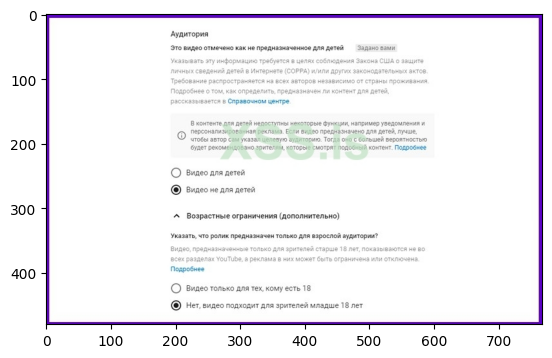

-----------------------------------------------------------------


3002074973, 16618259,"CLASICA NACIONAL VISA", 4555001074931162,"EVANGELIN ALFARO GONZALEZ",,,,"GOYA 566",, PROVIDENCIA, GUADALAJARA, JAL, 44630,013,6425842," "
3002074974, 16618261,"EMPRESARIAL NACIONAL VISA", 4555060120918367,"FEDERICO ALFARO HERNANDEZ", FEDERICO, ALFARO, HERNANDEZ, "NADRO SA DE CV",,"LONDRES 107 PS-8 JUAREZ", CUAUHTEMOC, DF, 06600,,2072055, M
3002074975, 16618263,"EMPRESARIAL NACIONAL VISA", 4555060120917815,"ALFONSO ALFARO I", ALFONSO, ALFARO, I, "EDITORIAL TRILLAS SA DE CV",, "RIO CHURUBUSCO 385 GRAL", "BENITO JUAREZ", DF,03340, 688, 4233138, M
3002074976, 16618265, "ORO INTERNACIONAL VISA", 4555400103959907, "MIGUEL A ALFARO J", "MIGUEL A", ALFARO, J,"AVE INSURGENTES","102 COL","JOSE LOPEZ PORTILLO","CHETUMAL O BLANCO", QRO, 77000, 019, 8370988, M
3002074977, 16618267, "APROVACION GARANTIZADA MASTERC", 5445510152054367,"ADRIAN SERGI ALFARO LOPEZ",,,, BOKOBA, 221,"PEDREG SAN NICOLAS", TLALPAN, DF, 

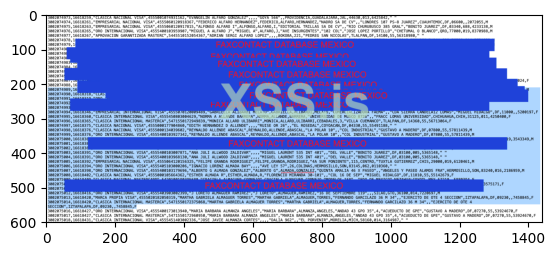

-----------------------------------------------------------------


О Мессенджер
A vk.com/im?sel=c168
а Поиск
к м Моргенштрн — Новый трек
Александр
АМоя страница
Общий чат
< Назад
276 участников
О Мессенджер
В Новости
О Мессенджер
Telegram Soft 20 мар в 19:28
A vk.com/im?sel=c168
8
Обновление 20.0з.2020: http://info.telegram-soft.ru/changelog/20_03_2020 п
е Друзья
..790
Управление
Александр Аменовский 16:55
Сообщества
ла
XSS.j:
О Фотографии
да
Все участники 276
Администраторы 4
Л Музыка
это и есть сесии софта
Видео
+ Добавить участников
В Клипы
Игры
Сергей Голодов 17:07
Создатель бе
заново открыть ни как?
В Тelegram Soft
н Мини-приложения
Александр Аменовский 17:09
Pavel Ivanov
Админист
Работа
регать в ручном режиме с тдаты копируя код
был в сети три часа назад
Александр Аменовский 19-44
Маркет
Кирилл Корнеев
Админист
олег дилеров напиши в лс свою тг
был в сети вчера в 19:09
k Закладки
Александр Мухин 20:38
Александр Аменовский
Администрато
Файлы
кто парсит номера с оlx напишите в ЛС
o

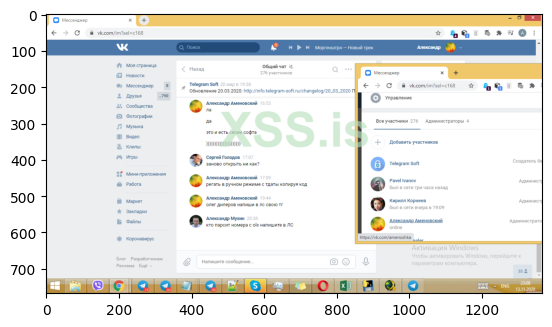

-----------------------------------------------------------------



----------Images with width over 5000 or height over 3000----------


Path: /content/drive/MyDrive/Data/Data_samples/forum_cncnz/5066ef21337a923ff37f3e5ec5f7d838.jpg, Width: 3167, Height: 3167 




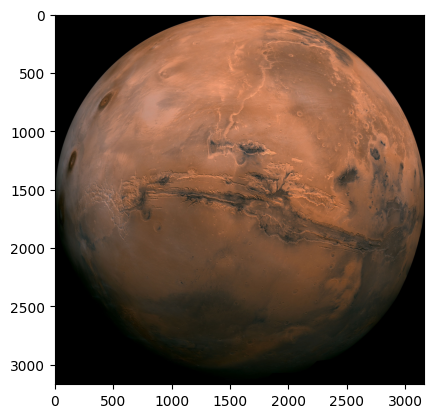

Path: /content/drive/MyDrive/Data/Data_samples/forum_ashiyane/01d5255f5261b1dab6c19775c0dbc34c.jpg, Width: 910, Height: 3792 




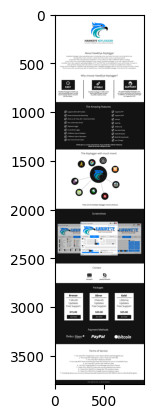

Path: /content/drive/MyDrive/Data/Data_samples/forum_bglife/4d1f69a0e7214e7d3872438752d3f8fd.jpg, Width: 2233, Height: 3155 




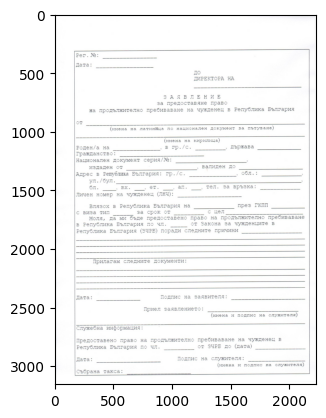

Path: /content/drive/MyDrive/Data/Data_samples/forum_digitalkaos/001a28d2b0815ba3fd6673799cbb5039.jpg, Width: 3120, Height: 4160 




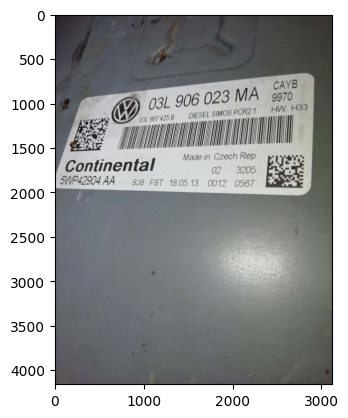

Path: /content/drive/MyDrive/Data/Data_samples/forum_forumkorner/194c67e465efeebe0a57bd030a424128.jpg, Width: 3167, Height: 3167 




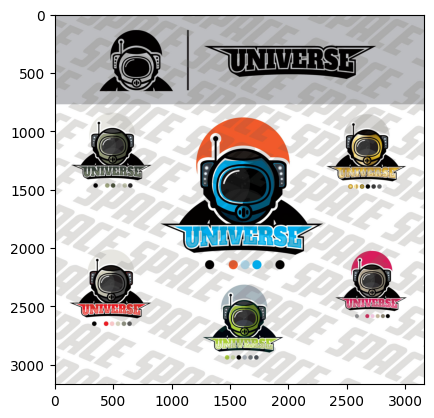

-------------------------------DONE!!!--------------------------------


In [22]:
# Execute EDA functions
find_anomalies(img_paths, texts);

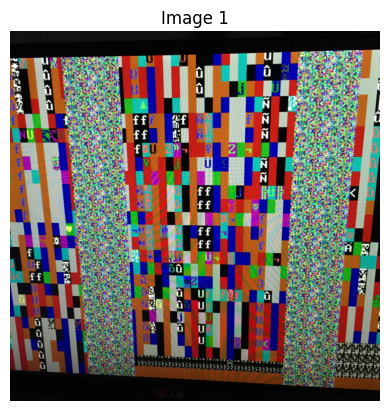

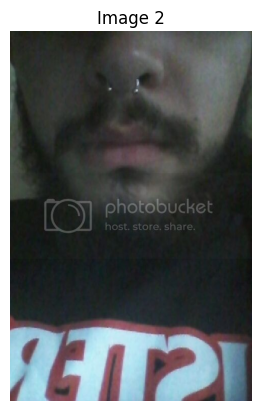

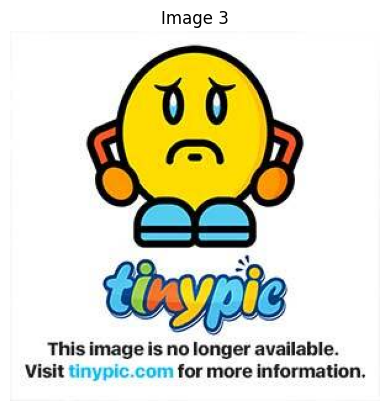

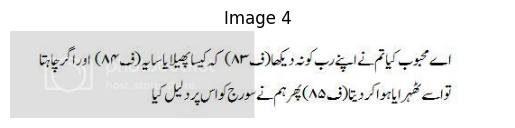

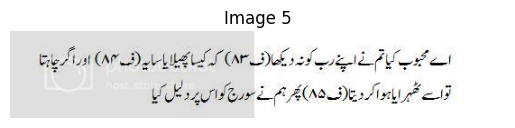

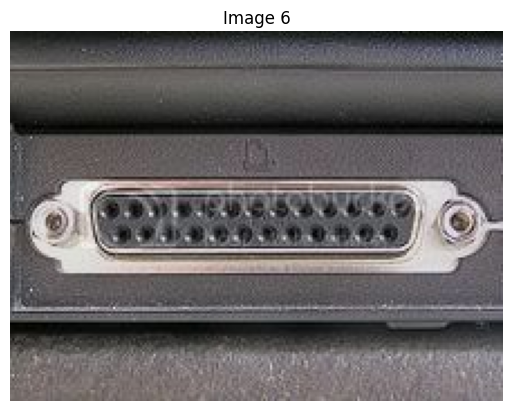

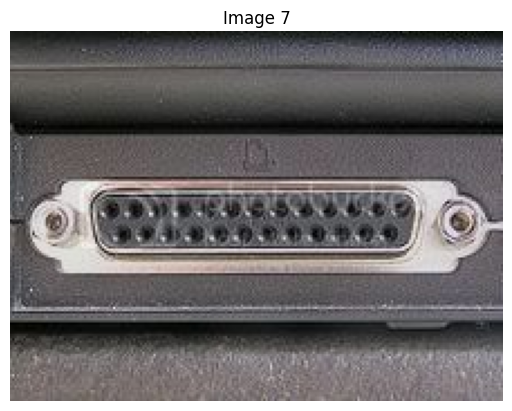

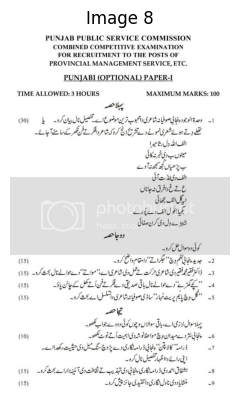

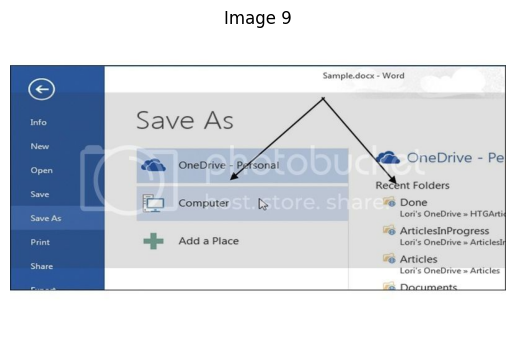

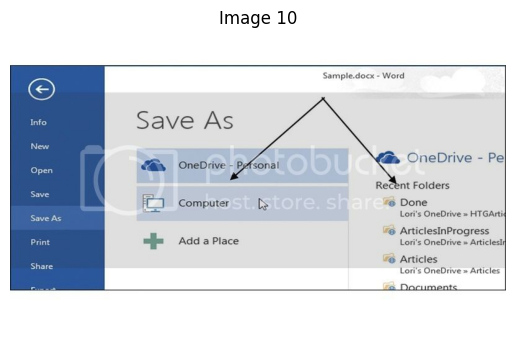

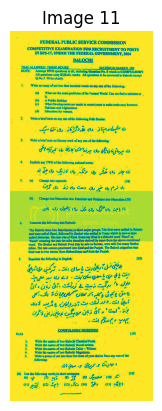

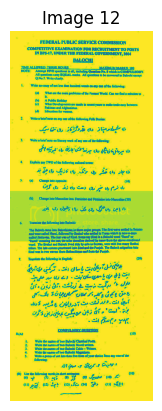

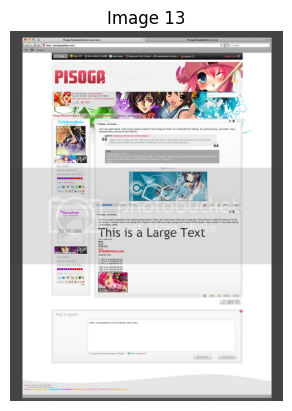

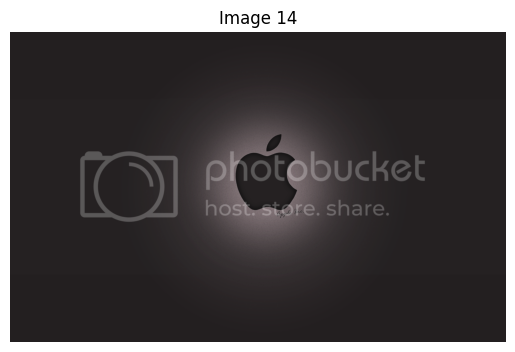

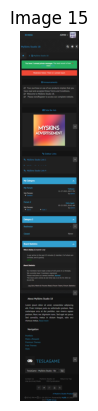

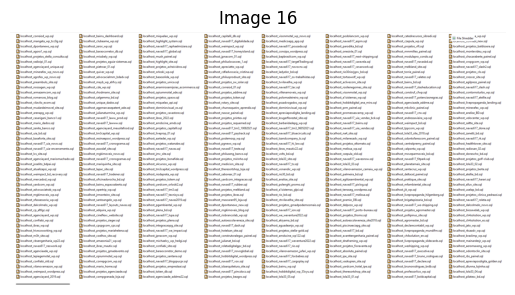

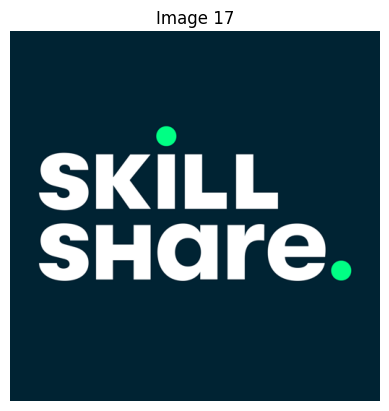

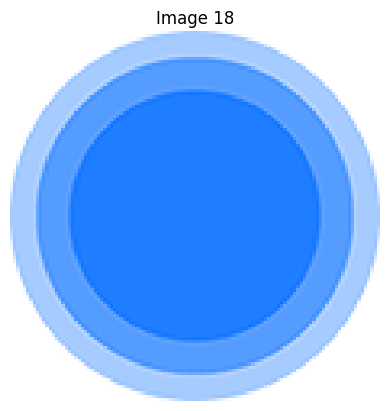

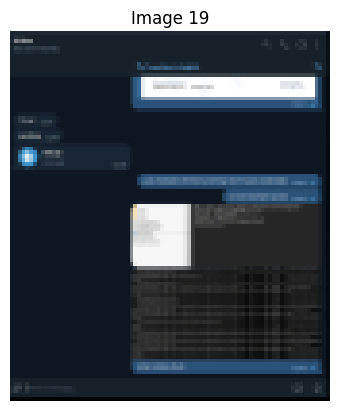

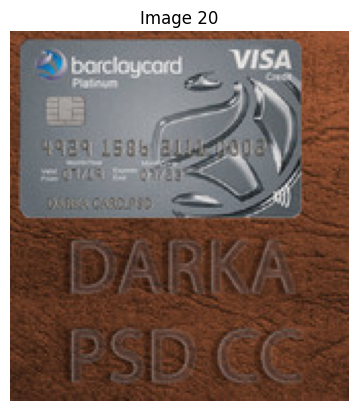

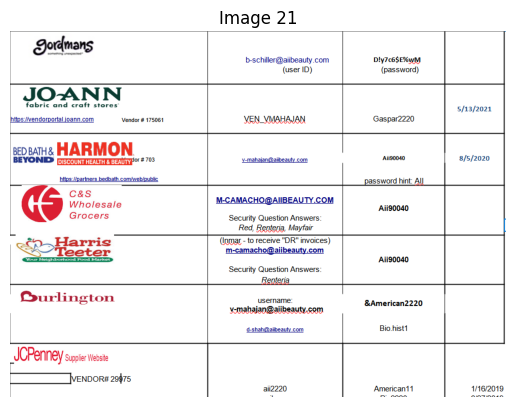

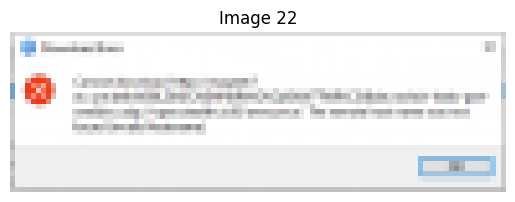

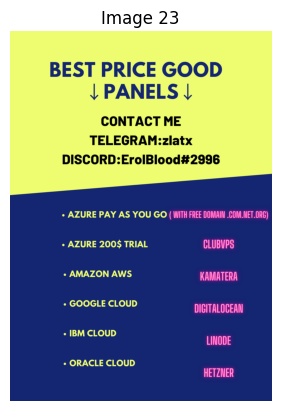

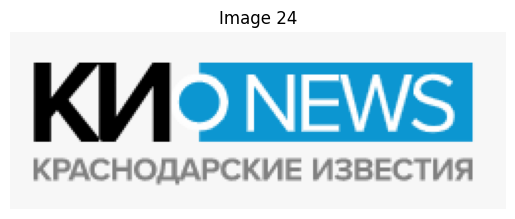

(24,
 ['/content/drive/MyDrive/Data/Data_samples/forum_forumkorner/1723061f0c317f2faa27f9193bb70e9d (1).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_forumkorner/1fac3bae0a135b4ef68b3fc32a8c0404 (1).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_forumkorner/37e9a9fca564bd196adff802f739ec81 (1).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/0158efb0a1beb8cb37b1064fdb8d899c (2).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/0158efb0a1beb8cb37b1064fdb8d899c (1).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/01e9cf7428895ddd0d5a7d4c4fa9ba73 (2).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/01e9cf7428895ddd0d5a7d4c4fa9ba73 (1).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/01f2879ce9645ec7f57bfcc53e91c3b8 (1).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/025bd48880e71f48c0fe791e3f28395c (2).jpg',
  '/content/drive/MyDrive/Data/Data_samples/forum_cssforum/025bd4888

In [23]:
# Execute EDA functions
find_images_without_json(root_folder=root_folder)

# Construct a .csv file

In [24]:
# text_annot = [annotation['text'] for annotation in texts]

# Create a DataFrame with the image paths and texts
# df = pd.DataFrame({
#    'file_path': img_paths,
#    'text': text_annot
# })

# display(df)


In [25]:
# Write the DataFrame to a CSV file
# csv_path = '/content/drive/MyDrive/OCR_Project/data.csv'
# df.to_csv(csv_path, index=False)

# Keep Exploring

In [26]:
data_path = '/content/drive/MyDrive/OCR_Project/data.csv'

df = pd.read_csv(data_path)

display(df)



file_path  \
0     /content/drive/MyDrive/Data/Data_samples/forum...   
1     /content/drive/MyDrive/Data/Data_samples/forum...   
2     /content/drive/MyDrive/Data/Data_samples/forum...   
3     /content/drive/MyDrive/Data/Data_samples/forum...   
4     /content/drive/MyDrive/Data/Data_samples/forum...   
...                                                 ...   
4863  /content/drive/MyDrive/Data/Data_samples/Data ...   
4864  /content/drive/MyDrive/Data/Data_samples/Data ...   
4865  /content/drive/MyDrive/Data/Data_samples/Data ...   
4866  /content/drive/MyDrive/Data/Data_samples/Data ...   
4867  /content/drive/MyDrive/Data/Data_samples/Data ...   

                                                   text  
0     Aloha\nW LEREEE\n3imL.\nT19\nucket\nAIR CALIFO...  
1     TAM\nVAAIR sano oCTORS\n*****\nphotobuckeł\nSI...  
2     Pre-Production Photo\ns ON\n909\n909\n5265\nTh...  
3     AIRCANADA\n.......\n..................\nWings9...  
4     DRAGON\nE Asiana\nisiviu ini\n- Asiana Airline...  
...                                                 ...  
4863                                 hacked by Kro0oz\n  
4864  HACKED BY KINGSAN PAKISTAN ZINDABAD KASHMIR ZI...  
4865  Hacked By KingSkrupellos CyBe RIZM\nTechnologi...  
4866  Hacked By Mr.Kro0oz.305\nKrZSec\n"Everything's...  
4867                              Hacked By Re4SploIT\n  

[4868 rows x 2 columns]

In [27]:
df['text'].fillna(' ', inplace=True)

In [28]:
number_of_nans = df['text'].isna().sum()

print(f"Number of missing or NaN values in 'text' column: {number_of_nans}")

Number of missing or NaN values in 'text' column: 0


In [29]:
max_length = df['text'].map(len).max()

print(max_length)

25629


(-0.5, 1513.5, 1579.5, -0.5)

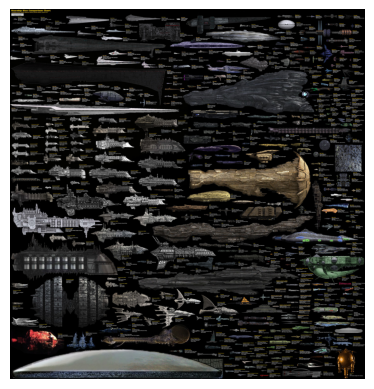

In [30]:
row_with_max_length = df[df['text'].map(len) == max_length].iloc[0]

image_path = row_with_max_length['file_path']

image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.axis('off')

In [31]:
def preprocess_images(df, output_height, output_width, output_path):
    """
    Preprocesses images by resizing and converting to RGB.

    :param df: DataFrame with file paths
    :param output_height: Height for resized images
    :param output_width: Width for resized images
    :param output_path: Path to save processed images
    """
    for index, row in df.iterrows():
        image_path = row['file_path']
        image = Image.open(image_path).convert("RGB")
        image_resized = image.resize((output_width, output_height))
        image_resized.save(output_path)

output_path = '/content/drive/MyDrive/OCR_Project/processed_images'
# preprocess_images(df, 224, 224, output_path)


In [33]:
def find_duplicates(df, column_name='file_path'):
    """
    Identifies all duplicate images in the given DataFrame using perceptual hashing.

    Parameters:
    df (DataFrame): A DataFrame containing file paths to the images.
    column_name (str, optional): The name of the column containing the file paths. Defaults to 'file_path'.

    Returns:
    list: A list of tuples, each containing file paths to images that are duplicates of each other.
    """
    hashes = defaultdict(list)
    duplicates = []

    for index, row in df.iterrows():
        path = row[column_name]
        with Image.open(path) as img:
            h = imagehash.dhash(img)
            hashes[h].append(path)

    for h, paths in hashes.items():
        if len(paths) > 1:
            duplicates.append(tuple(paths))

    return duplicates

In [35]:
duplicates = find_duplicates(df)

In [36]:
# Print the total number of duplicate paths
total_duplicate_paths = sum(len(paths) for paths in duplicates)
print(f"Total number of duplicate paths: {total_duplicate_paths}")

Total number of duplicate paths: 558


In [37]:
# Print the number of types of duplicates
total_duplicate_types = len(duplicates)
print(f"Total number of types of duplicates: {total_duplicate_types}")

Total number of types of duplicates: 100


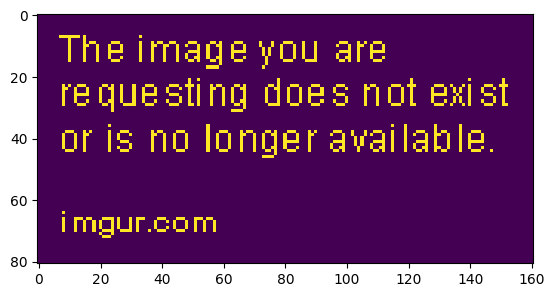

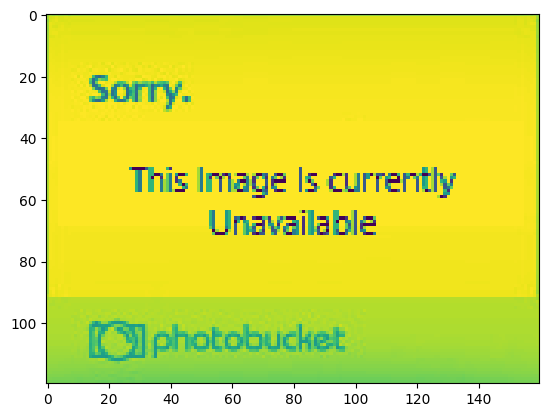

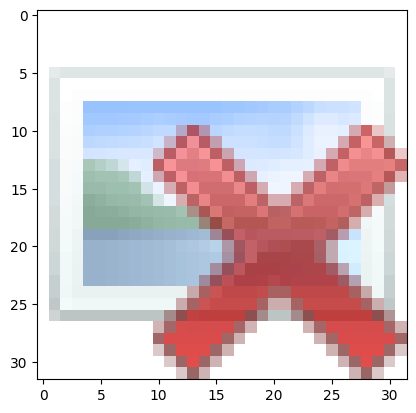

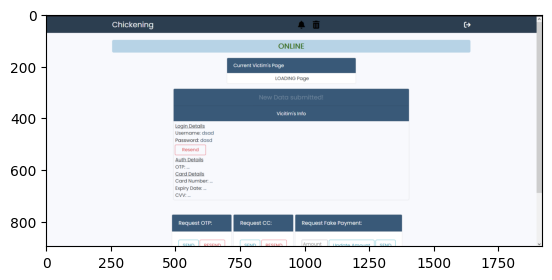

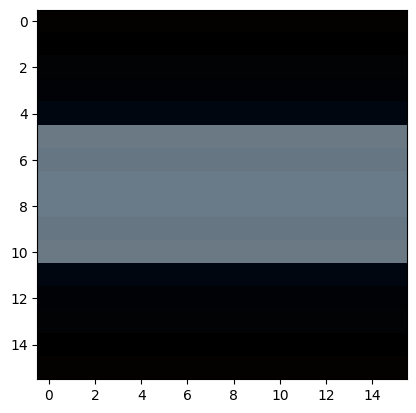

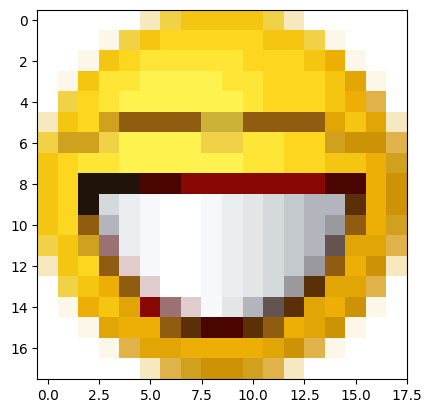

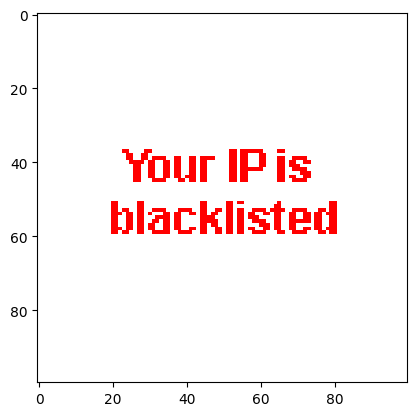

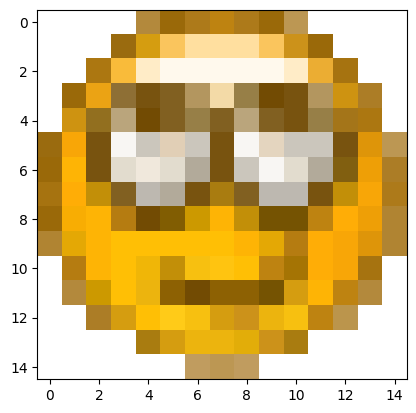

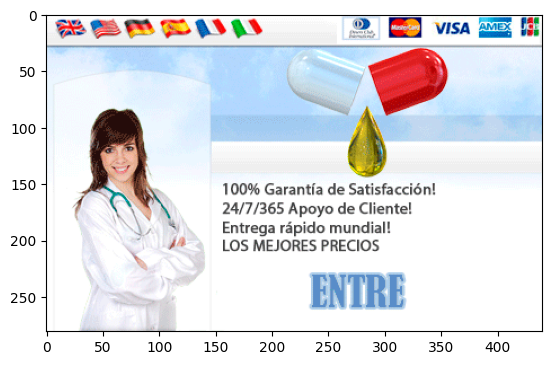

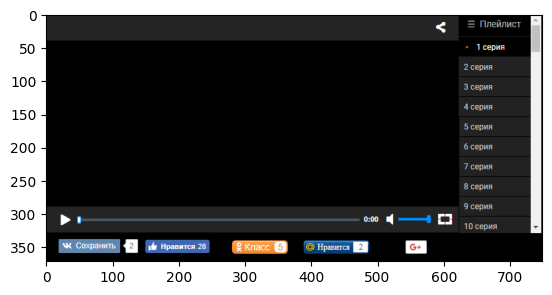

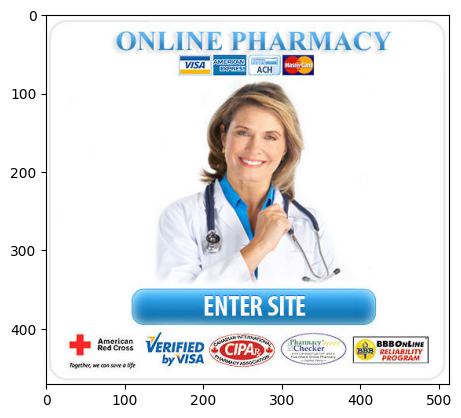

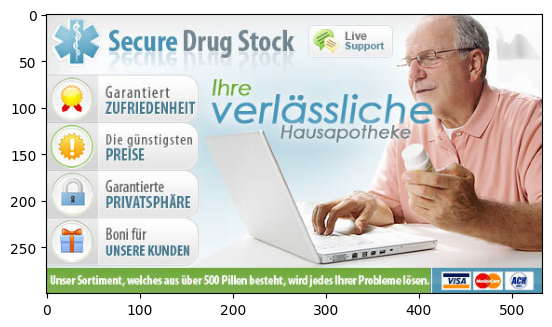

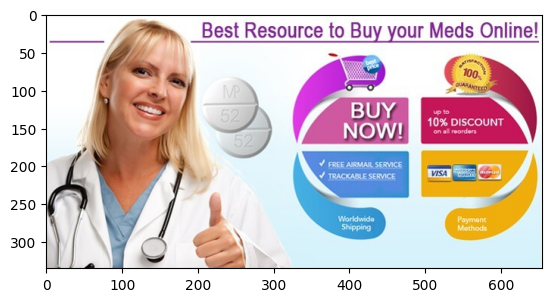

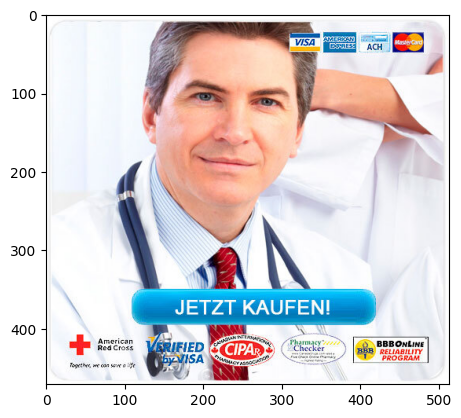

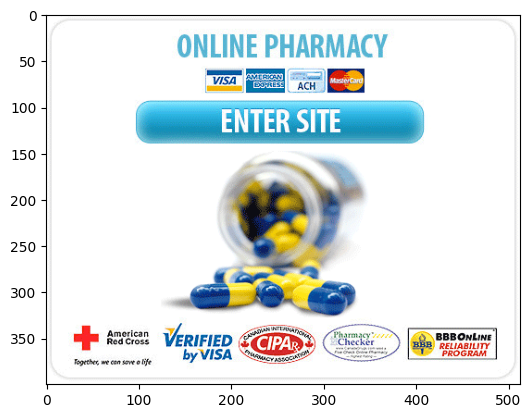

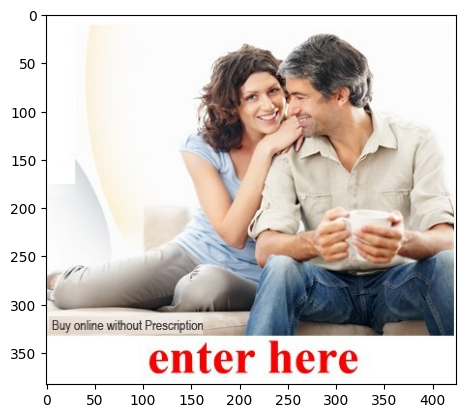

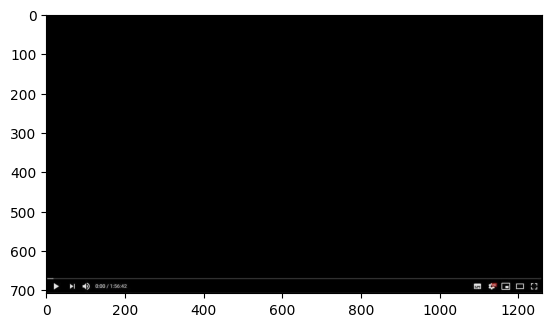

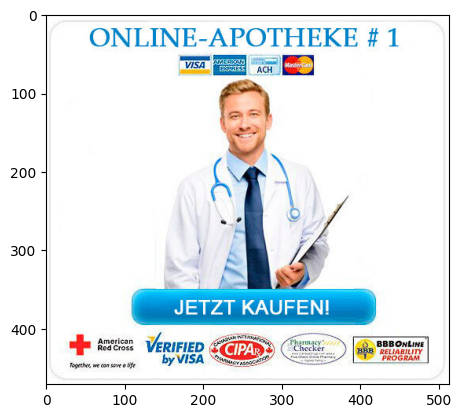

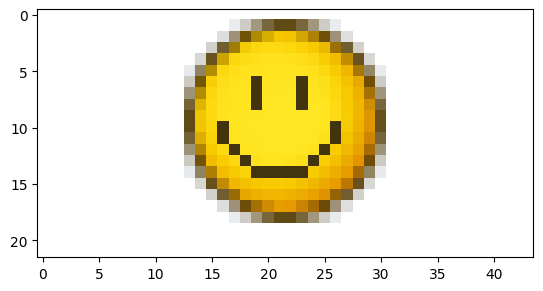

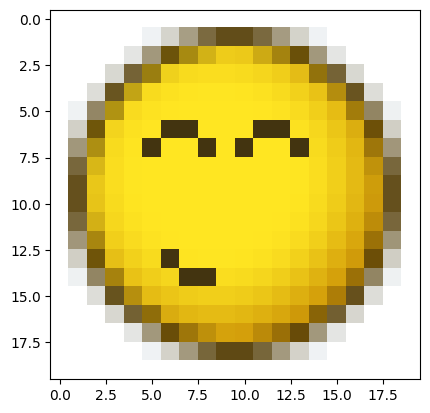

In [41]:
counter = 0
n=20
for paths in duplicates:
    if counter >= n:
        break

    sample_image_path = paths[0]
    img = Image.open(sample_image_path)

    plt.imshow(img)
    plt.show()
    counter += 1


In [42]:
def find_one_color_images(df, column_name='file_path'):
    """
    Identifies images in the given DataFrame that consist of a single color.

    Parameters:
    df (DataFrame): A DataFrame containing file paths to the images.
    column_name (str, optional): The name of the column in the DataFrame containing the file paths. Defaults to 'file_path'.

    Returns:
    list: A list of file paths to the images that consist of a single color.
    """
    one_color_images = []

    for index, row in df.iterrows():
        image_path = row[column_name]
        image = Image.open(image_path).convert("RGB")
        pixels = np.array(image)
        first_pixel = pixels[0, 0]

        if (pixels == first_pixel).all():
            one_color_images.append(image_path)

    return one_color_images

In [43]:
one_color_images = find_one_color_images(df)
print(len(one_color_images))

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


35


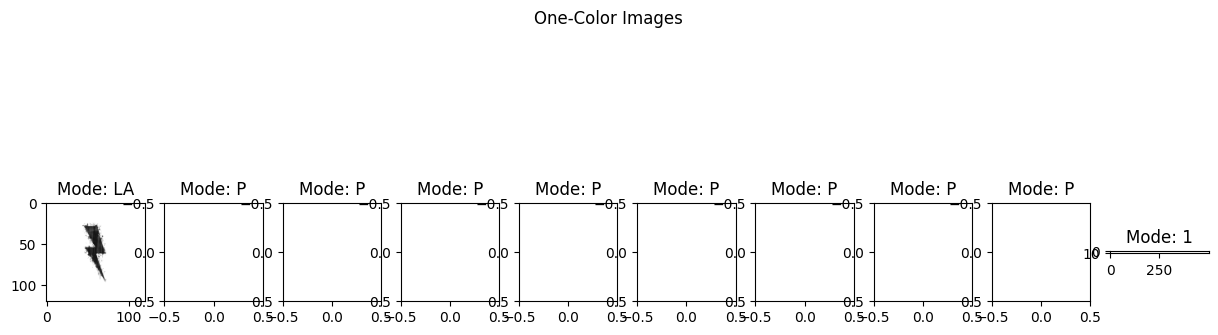

In [44]:
ex_m = 10
plt.figure(figsize=(15, 5))
for i, path in enumerate(one_color_images[:ex_m]):
    image = Image.open(path)
    plt.subplot(1, ex_m, i + 1)
    plt.imshow(image)
    plt.title(f"Mode: {image.mode}")
    plt.axis('on')
plt.suptitle('One-Color Images')
plt.show()


In [45]:
def find_almost_identical_images(df, threshold=1, column_name='file_path'):
    """
    Identifies almost identical images in the given DataFrame using perceptual hashing.

    Parameters:
    df (DataFrame): A DataFrame containing file paths to the images.
    column_name (str, optional): The name of the column in the DataFrame containing the file paths. Defaults to 'file_path'.
    threshold (int, optional): The maximum hash difference to consider two images almost identical. Defaults to 1.

    Returns:
    list: A list of tuples, each containing a pair of file paths to almost identical images.
    """
    hashes = defaultdict(list)
    almost_identical = []

    for index, row in df.iterrows():
        path = row[column_name]
        with Image.open(path) as img:
            h = imagehash.dhash(img)
            for stored_hash, paths in hashes.items():
                if h - stored_hash <= threshold and h - stored_hash > 0:
                    for stored_path in paths:
                        almost_identical.append((path, stored_path))
            hashes[h].append(path)

    return almost_identical


In [46]:
almost_identical = find_almost_identical_images(df)


In [47]:
len(almost_identical)

115

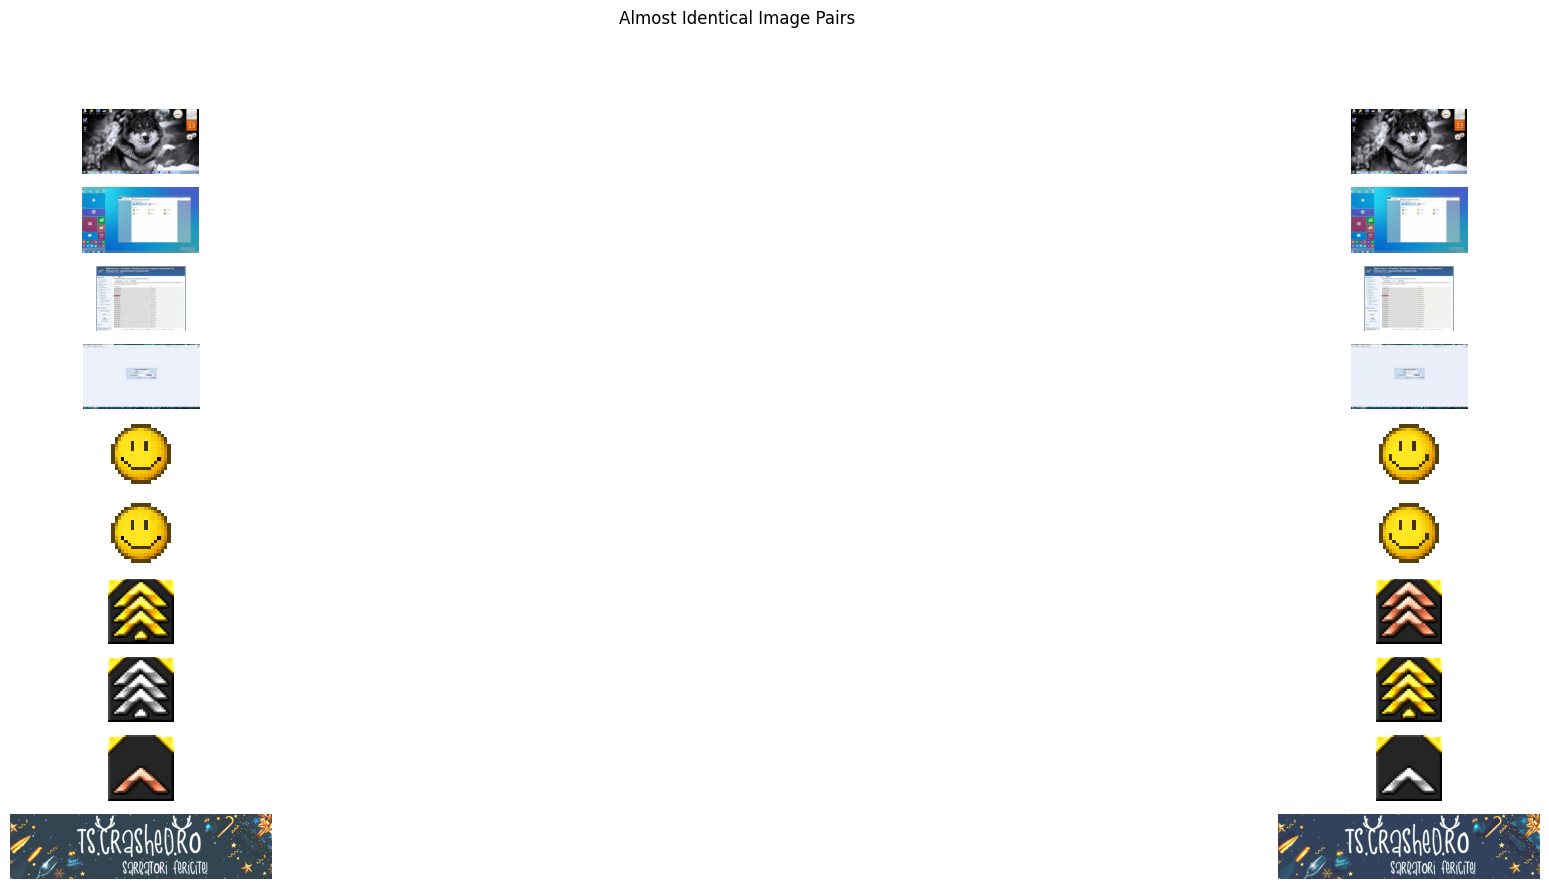

In [50]:
ex_almost = 10
plt.figure(figsize=(30, 10))
for i, (path1, path2) in enumerate(almost_identical[0:ex_almost]):
    image1 = Image.open(path1)
    image2 = Image.open(path2)
    plt.subplot(ex_almost, 2, 2 * i + 1)
    plt.imshow(image1)
    plt.axis('off')
    plt.subplot(ex_almost, 2, 2 * i + 2)
    plt.imshow(image2)
    plt.axis('off')
plt.suptitle('Almost Identical Image Pairs')
plt.show()

# Screening

In [51]:
# removing dupes
paths_to_remove = [path for duplicate_group in duplicates for path in duplicate_group[1:]]
df = df[~df['file_path'].isin(paths_to_remove)]


In [52]:
duplicates = find_duplicates(df)
total_duplicate_paths = sum(len(paths) for paths in duplicates)
print(f"Total number of duplicate paths: {total_duplicate_paths}")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total number of duplicate paths: 0


In [53]:
# removing one-color images
df = df[~df['file_path'].isin(one_color_images)]

In [54]:
# removing almost identical
for pair in almost_identical:
    # Assuming we want to remove one/both occurrences
    df = df[df['file_path'] != pair[0]]
    # df = df[df['file_path'] != pair[1]]

In [55]:
cleaned_data_path = '/content/drive/MyDrive/OCR_Project/cleaned_data.csv'
# df.to_csv(cleaned_data_path, index=False)


In [78]:
data_path = cleaned_data_path

df_clean = pd.read_csv(data_path)

display(df_clean)

file_path  \
0     /content/drive/MyDrive/Data/Data_samples/forum...   
1     /content/drive/MyDrive/Data/Data_samples/forum...   
2     /content/drive/MyDrive/Data/Data_samples/forum...   
3     /content/drive/MyDrive/Data/Data_samples/forum...   
4     /content/drive/MyDrive/Data/Data_samples/forum...   
...                                                 ...   
4375  /content/drive/MyDrive/Data/Data_samples/Data ...   
4376  /content/drive/MyDrive/Data/Data_samples/Data ...   
4377  /content/drive/MyDrive/Data/Data_samples/Data ...   
4378  /content/drive/MyDrive/Data/Data_samples/Data ...   
4379  /content/drive/MyDrive/Data/Data_samples/Data ...   

                                                   text  
0     Aloha\nW LEREEE\n3imL.\nT19\nucket\nAIR CALIFO...  
1     TAM\nVAAIR sano oCTORS\n*****\nphotobuckeł\nSI...  
2     Pre-Production Photo\ns ON\n909\n909\n5265\nTh...  
3     AIRCANADA\n.......\n..................\nWings9...  
4     DRAGON\nE Asiana\nisiviu ini\n- Asiana Airline...  
...                                                 ...  
4375  ESTUDIO\nFITZGERALD\nINICIO\nNOSOTROS\nSERVICI...  
4376  #OpsPatuk\nLakum dinukum waliya din., For you ...  
4377  Why so Serious??\nI'm still Learning, still St...  
4378  HACKED BY KINGSAN PAKISTAN ZINDABAD KASHMIR ZI...  
4379  Hacked By KingSkrupellos CyBe RIZM\nTechnologi...  

[4380 rows x 2 columns]

hi

In [ ]:
counter = 0


In [ ]:
def get_image_language_counter(image_path):
    global counter  # Declare the variable as global
    img = Image.open(image_path)
    text = pytesseract.image_to_string(img)
    try:
        language = detect(text)
    except LangDetectException: # Handle the exception
        language = 'unknown'
    print(f"get_image_language was applied {counter} times.")
    counter += 1
    return language

In [79]:
def get_image_language(image_path):
    img = Image.open(image_path)
    text = pytesseract.image_to_string(img)
    try:
        language = detect(text)
    except LangDetectException: # Handle the exception
        language = 'unknown'
    print("get_image_language was applied...")
    return language



In [80]:
df_clean['language'] = df_clean['file_path'].apply(get_image_language)


get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_language was applied...
get_image_lang

In [83]:
df_clean.head(20)

file_path  \
0   /content/drive/MyDrive/Data/Data_samples/forum...   
1   /content/drive/MyDrive/Data/Data_samples/forum...   
2   /content/drive/MyDrive/Data/Data_samples/forum...   
3   /content/drive/MyDrive/Data/Data_samples/forum...   
4   /content/drive/MyDrive/Data/Data_samples/forum...   
5   /content/drive/MyDrive/Data/Data_samples/forum...   
6   /content/drive/MyDrive/Data/Data_samples/forum...   
7   /content/drive/MyDrive/Data/Data_samples/forum...   
8   /content/drive/MyDrive/Data/Data_samples/forum...   
9   /content/drive/MyDrive/Data/Data_samples/forum...   
10  /content/drive/MyDrive/Data/Data_samples/forum...   
11  /content/drive/MyDrive/Data/Data_samples/forum...   
12  /content/drive/MyDrive/Data/Data_samples/forum...   
13  /content/drive/MyDrive/Data/Data_samples/forum...   
14  /content/drive/MyDrive/Data/Data_samples/forum...   
15  /content/drive/MyDrive/Data/Data_samples/forum...   
16  /content/drive/MyDrive/Data/Data_samples/forum...   
17  /content/drive/MyDrive/Data/Data_samples/forum...   
18  /content/drive/MyDrive/Data/Data_samples/forum...   
19  /content/drive/MyDrive/Data/Data_samples/forum...   

                                                 text language  
0   Aloha\nW LEREEE\n3imL.\nT19\nucket\nAIR CALIFO...  unknown  
1   TAM\nVAAIR sano oCTORS\n*****\nphotobuckeł\nSI...  unknown  
2   Pre-Production Photo\ns ON\n909\n909\n5265\nTh...       en  
3   AIRCANADA\n.......\n..................\nWings9...       en  
4   DRAGON\nE Asiana\nisiviu ini\n- Asiana Airline...  unknown  
5   The image you are\nreque sting does not exist\...       en  
6                               HEWITT\n2 HARRY\n8.\n  unknown  
7   53038\nNORTHWEST O\nU000000000000\n.00000\n000...  unknown  
8                       55061\nEthiopian..\nBeijing\n       fi  
9   TWA\nBritish Caledonian m\nKLM\nKSREAN AIR\nAv...  unknown  
10                                  DOP\nrobertjon5\n       sl  
11                       TriStar\nAeroPeru\nNIOI 14\n  unknown  
12                                                     unknown  
13  .Emirates.\n..........\n......\nwww.emirates.c...  unknown  
14  .. United\nphotebotkket\nA EASTERN\nost store ...  unknown  
15           Gir florida\nairflorica\n146 a .....RE\n  unknown  
16                                              319\n  unknown  
17  33\nROYAL AIR FORCE\n0 0 0 0 0 0 0 0 0 0 0 0 0...       nl  
18   DIB\nphotobucket.\nEC-DIB\nhost. store. share.\n  unknown  
19         Luthane\nphotobucket\nhost. store share.\n  unknown

In [82]:
english_data_path = '/content/drive/MyDrive/OCR_Project/english_flag_data.csv'
# df_clean.to_csv(english_data_path, index=False)

hi


In [86]:
df_non_english = df_clean[df_clean['language'] != 'en']

Language detected: unknown


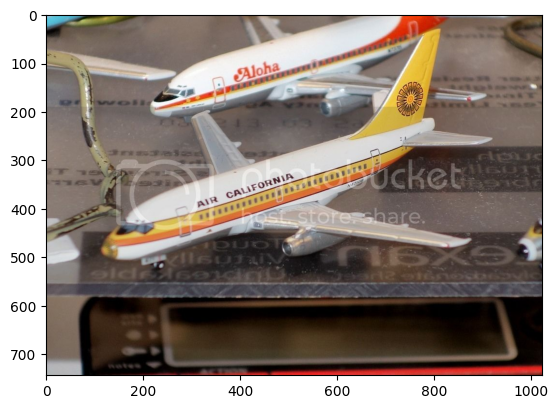

Language detected: unknown


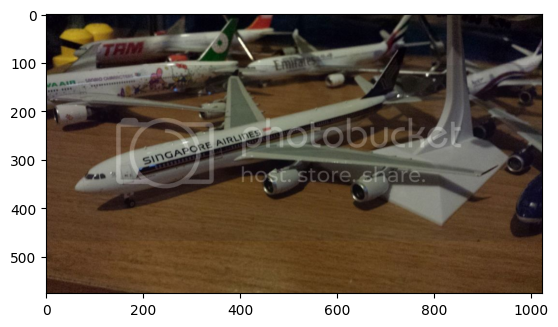

Language detected: unknown


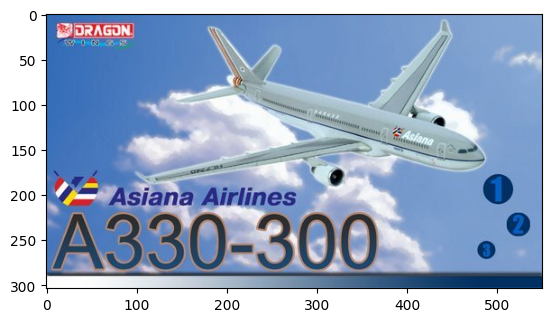

Language detected: unknown


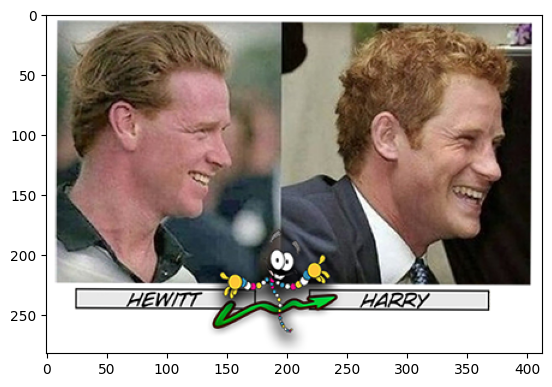

Language detected: unknown


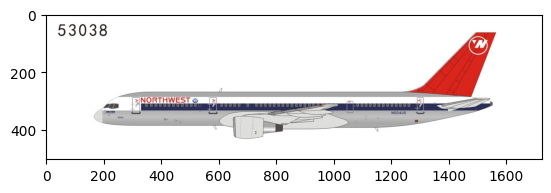

In [87]:
for index, row in df_non_english.head(n=5).iterrows(): # Display the first 5
    print(f"Language detected: {row['language']}")
    img = Image.open(row['file_path'])
    plt.imshow(img)
    plt.show()